In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
prediction = pd.read_csv('results/prediction_sqf_rnn_task15.csv').set_index(['TIMESTAMP', 'ZONEID'])

actual = pd.read_csv('data/Task 16/train16.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')['2014-06-01 01:00':]\
    .reset_index().set_index(['TIMESTAMP', 'ZONEID'])

In [3]:
def sample(quantiles, n):
    ps = np.random.choice(a=[str(p / 100) for p in range(1, 100)], size=n, replace=True)
    xs = quantiles[ps]
    return np.array(xs)[None,...]

sampled = sample(prediction.iloc[0], 20)

In [4]:
def energy_score(quantiles, y, n=100):
    """
    Calculates the energy score.
    :param quantiles: np array (99,)
    :param y: (d,)
    :param n: number of samples
    :return:
    """
    xs = sample(quantiles, n)
    s1 = np.mean(np.linalg.norm(xs - y, axis=0))
    s2 = - 1 / 2 * np.mean(np.linalg.norm(xs[None, ...] - xs[None, ...].T, axis=1))
    return s1 + s2

# energy_score for first prediction point
energy_score(prediction.iloc[0], np.array(actual.iloc[0]))

0.06763465664407439

<AxesSubplot:ylabel='Count'>

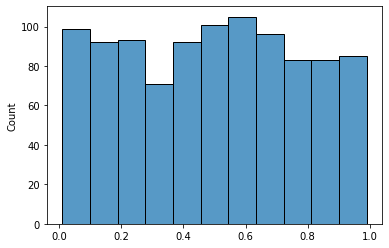

In [5]:
def cdf(quantiles, x):
    s = x <= quantiles
    if len(s[s==True]) == 0:
        return 0
    return float(s[s==True].index[0])

quantiles = prediction.iloc[0]

n = 1000
sampled = sample(quantiles, n)
xs = []
for i in range(n):
    xs.append(cdf(quantiles, np.squeeze(sampled[:,i])))
xs = np.array(xs)

sns.histplot(data=xs)